I have used the following methods.

* I used a model created with <b>ConvMixer </b> blocks [1,2],
* <b>gelu</b> activation function during the feature extraction stage,
* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,
* I split the full data into train (15425 images), validation (812 images) and test (855 images)


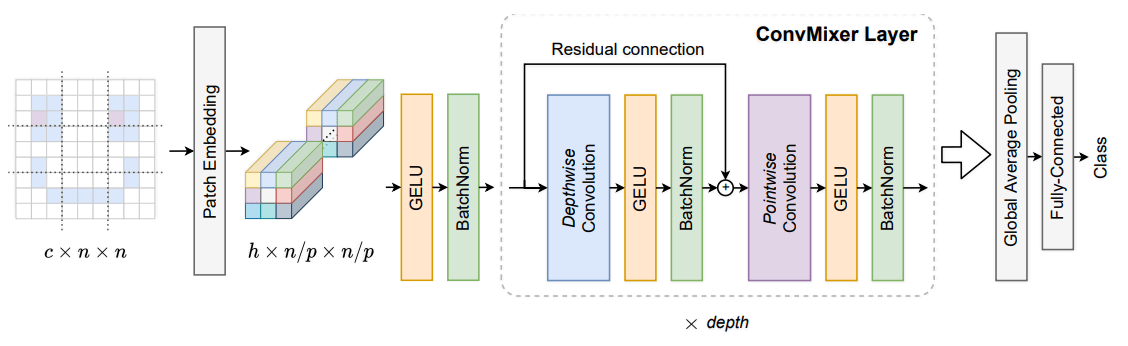

<i> ConvMixer Layer from the paper [1]</i>

## Test Set Predictions
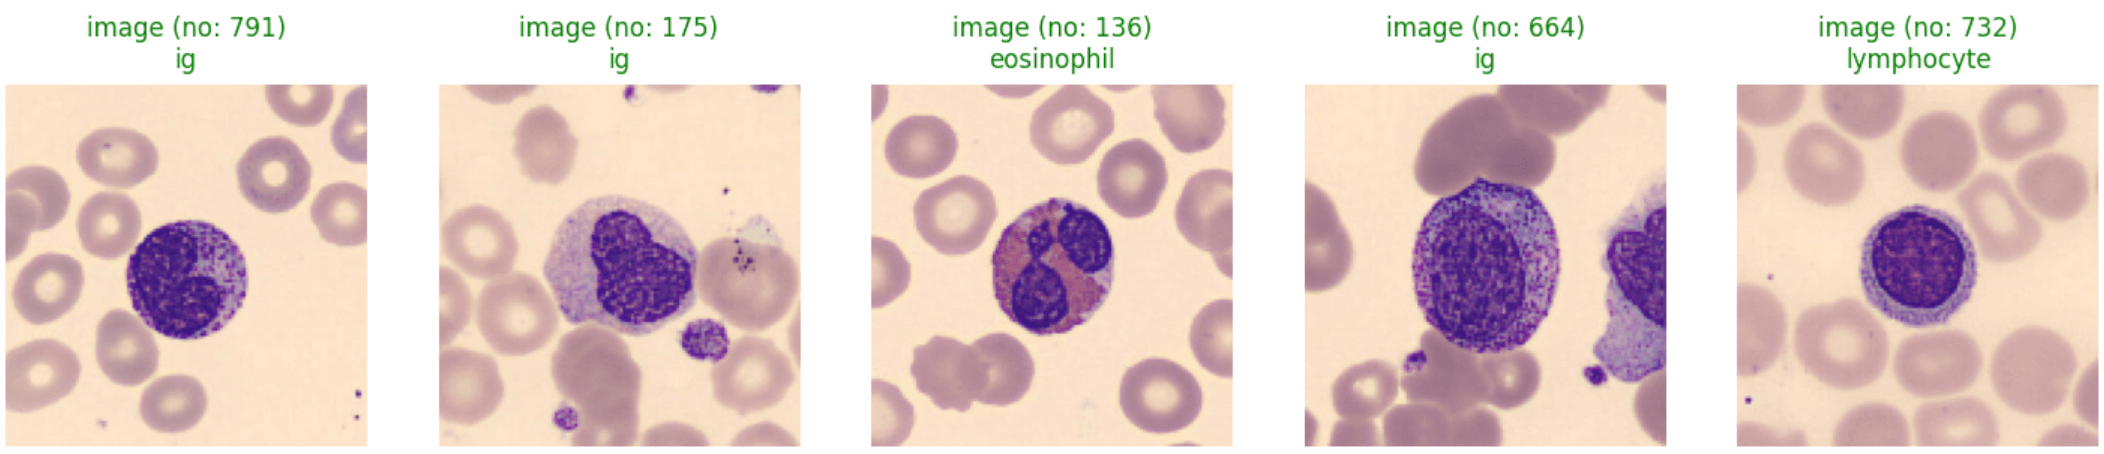
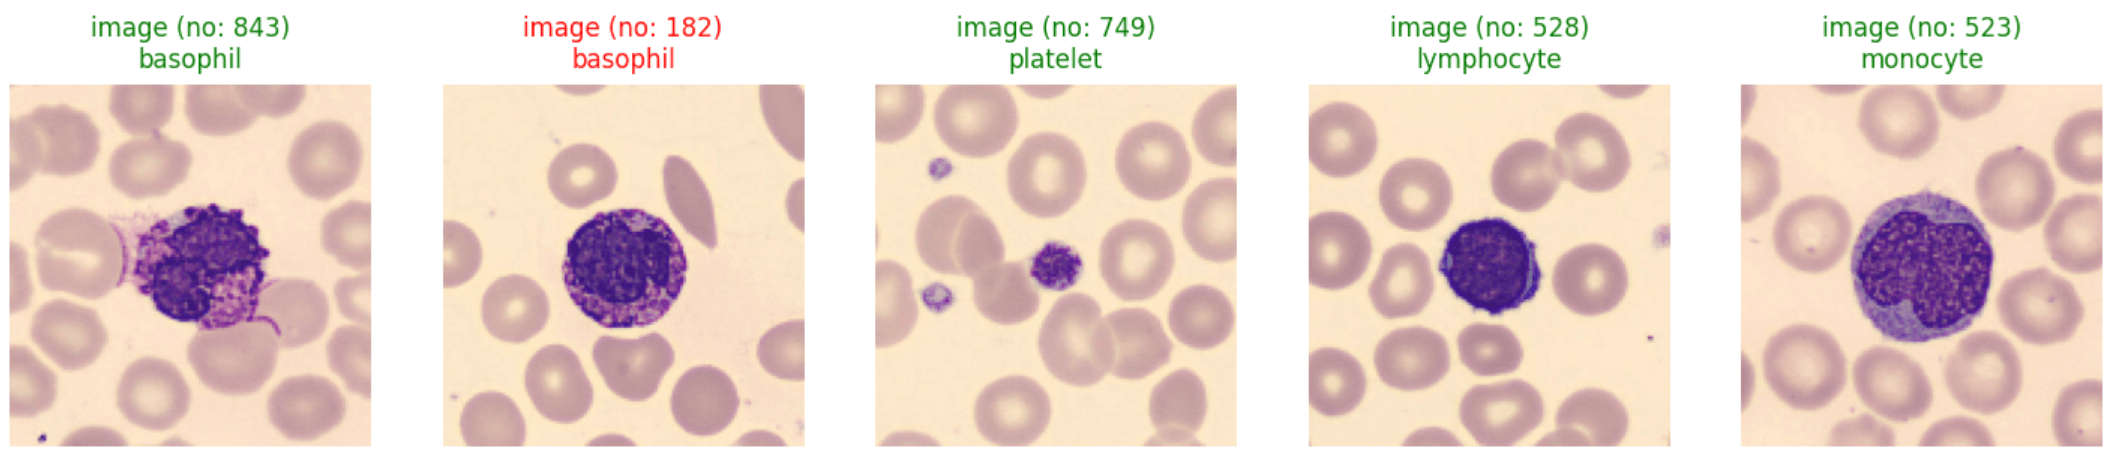

## My Another Projects
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMG_SIZE = 128, 128
BATCH_SIZE = 128
SEED = 10
AUTO = tf.data.AUTOTUNE

D1018 19:54:30.578244828      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1018 19:54:30.578274540      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1018 19:54:30.578279423      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1018 19:54:30.578283158      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1018 19:54:30.578287058      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1018 19:54:30.578298981      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1018 19:54:30.578302636      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1018 19:54:30.

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [3]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


data_basophil = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/basophil')
data_eosinophil = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/eosinophil')
data_erythroblast = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/erythroblast')
data_ig = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/ig')
data_lymphocyte = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/lymphocyte')
data_monocyte = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/monocyte')
data_neutrophil = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/neutrophil')
data_platelet = create_images_list('/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/platelet')


# look-up table
disease_classes = {0:'basophil',
                1 : 'eosinophil',
                2 : 'erythroblast',
                3 : 'ig',
                4 : 'lymphocyte',
                5 : 'monocyte',
                6 : 'neutrophil',
                7 : 'platelet'}

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_basophil) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_eosinophil) , "label": 1 }),
                        pd.DataFrame({"img" : np.array(data_erythroblast) , "label": 2 }),
                        pd.DataFrame({"img" : np.array(data_ig) , "label": 3 }),
                        pd.DataFrame({"img" : np.array(data_lymphocyte) , "label": 4 }),
                        pd.DataFrame({"img" : np.array(data_monocyte) , "label": 5 }),
                        pd.DataFrame({"img" : np.array(data_neutrophil) , "label": 6 }),
                        pd.DataFrame({"img" : np.array(data_platelet) , "label": 7 })
                     ], ignore_index = True)

data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets


In [4]:
X_data, X_test, y_data, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.05, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.05, random_state = SEED + 1)

print("X_train shape -> ", X_train.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (15425,)
X_val shape ->  (812,)
X_test shape ->  (855,)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
def img_preprocessing(image, label):
    
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    return image, label

In [6]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_train.shape[0])
                 .prefetch(AUTO))

validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [7]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            }

# <span style="color:#e74c3c;"> Model</span>


In [8]:
FEATURES = 256
with strategy.scope():
    inp = Input(shape = (*IMG_SIZE, 3))

    X = Conv2D(FEATURES, 2, 2)(inp)
    X = Activation('gelu')(X)
    X = BatchNormalization()(X)

    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)

    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
    X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)
    

    X = GlobalAveragePooling2D()(X)
    out = Dense(8, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()

    
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       3328      
                                                                 
 activation (Activation)     (None, 64, 64, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 64, 64, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 64, 64, 256)      74496 

# <span style="color:#e74c3c;"> Training</span> 

In [9]:
hist = model.fit(train_dataset, epochs = 15, batch_size = BATCH_SIZE, validation_data = validation_dataset)

Epoch 1/15


2023-10-18 19:55:00.792385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-18 19:55:01.151791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


121/121 [==============================] - ETA: 0s - loss: 0.5022 - acc: 0.8519

2023-10-18 19:55:40.791260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-18 19:55:40.929970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


121/121 [==============================] - 58s 268ms/step - loss: 0.5022 - acc: 0.8519 - val_loss: 4.1342 - val_acc: 0.1429
Epoch 2/15
121/121 [==============================] - 11s 81ms/step - loss: 0.1791 - acc: 0.9446 - val_loss: 6.5466 - val_acc: 0.1429
Epoch 3/15
121/121 [==============================] - 11s 83ms/step - loss: 0.1185 - acc: 0.9628 - val_loss: 7.6760 - val_acc: 0.1022
Epoch 4/15
121/121 [==============================] - 11s 80ms/step - loss: 0.0982 - acc: 0.9693 - val_loss: 16.0252 - val_acc: 0.1022
Epoch 5/15
121/121 [==============================] - 11s 80ms/step - loss: 0.0733 - acc: 0.9767 - val_loss: 5.3080 - val_acc: 0.1761
Epoch 6/15
121/121 [==============================] - 10s 80ms/step - loss: 0.0647 - acc: 0.9797 - val_loss: 0.9216 - val_acc: 0.7956
Epoch 7/15
121/121 [==============================] - 10s 80ms/step - loss: 0.0558 - acc: 0.9818 - val_loss: 7.7955 - val_acc: 0.4791
Epoch 8/15
121/121 [==============================] - 11s 79ms/step - l

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

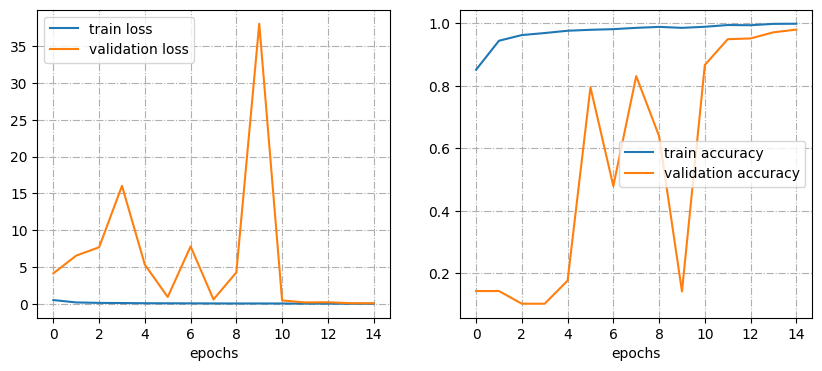

In [10]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['acc'])
axs[1].plot(hist.history['val_acc'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)

# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [11]:
with strategy.scope():
    test_eval = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))

7/7 [==============================] - 5s 739ms/step - loss: 0.0540 - acc: 0.9801
Test Loss: 0.054
Test Accuracy: 98.012 %


In [12]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

2023-10-18 19:58:33.371285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-18 19:58:33.503975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


7/7 [==============================] - 8s 665ms/step


# <span style="color:#e74c3c;"> Classification </span> Report

In [13]:
clf = classification_report(y_test , pred, target_names = list(disease_classes.values()))
print(clf)

              precision    recall  f1-score   support

    basophil       1.00      0.97      0.98        61
  eosinophil       1.00      1.00      1.00       164
erythroblast       0.98      1.00      0.99        64
          ig       0.98      0.93      0.96       136
  lymphocyte       0.97      1.00      0.98        61
    monocyte       0.98      0.95      0.96        85
  neutrophil       0.95      0.99      0.97       187
    platelet       1.00      1.00      1.00        97

    accuracy                           0.98       855
   macro avg       0.98      0.98      0.98       855
weighted avg       0.98      0.98      0.98       855



# <span style="color:#e74c3c;"> Confusion </span> Matrix

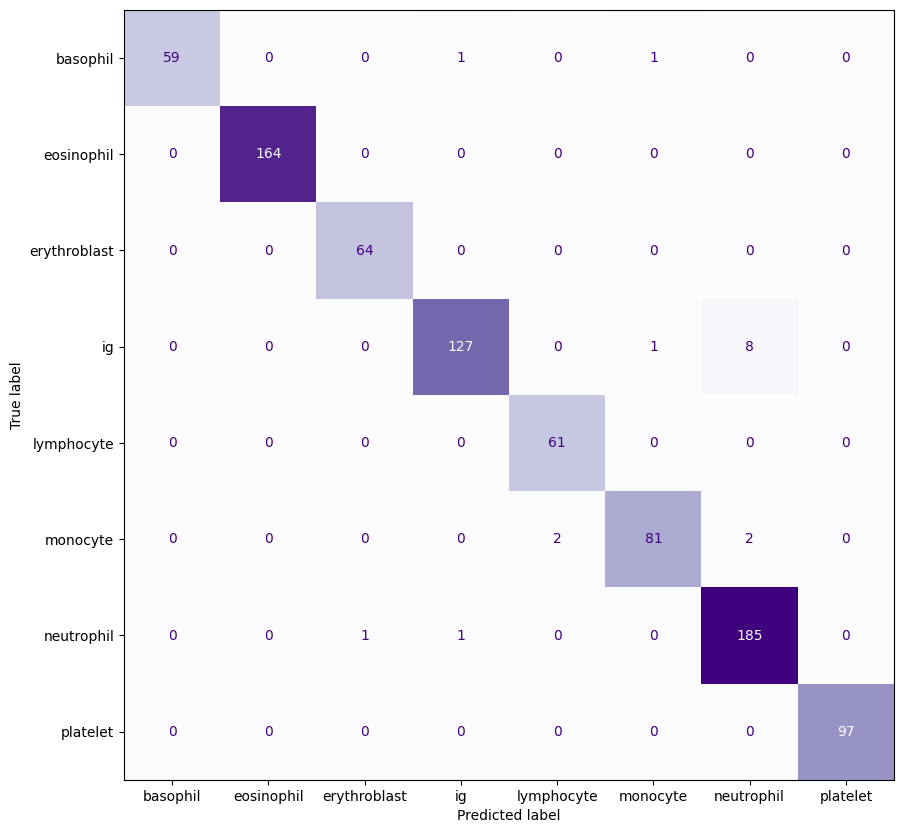

In [14]:
cm = confusion_matrix(y_test , pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(disease_classes.values()))

fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [15]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + disease_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + disease_classes[label], fontsize = 8, color = 'red')

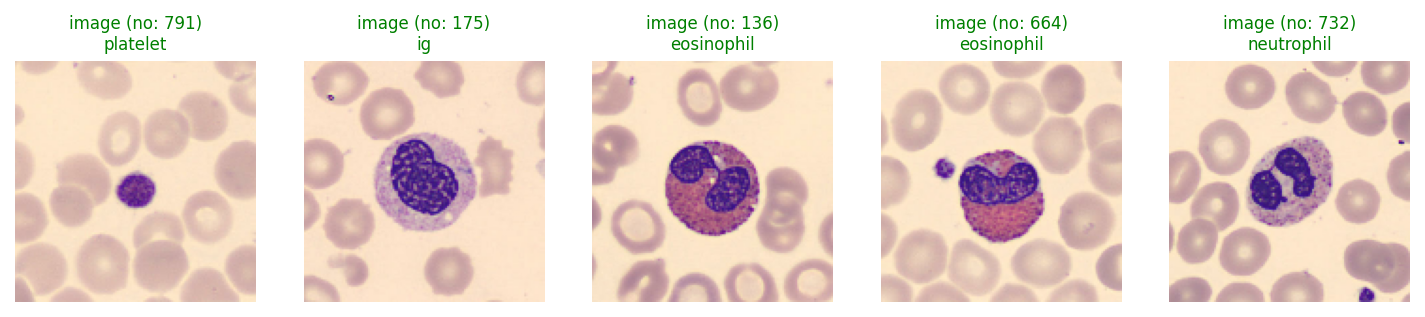

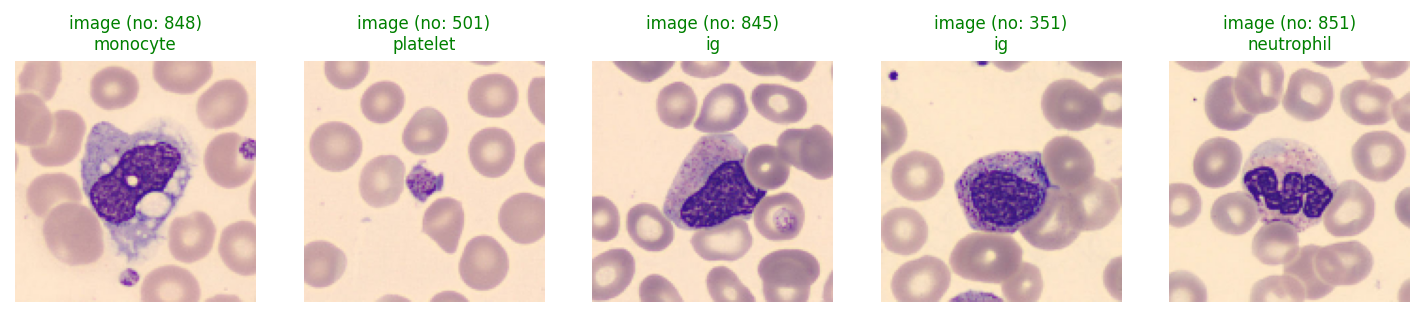

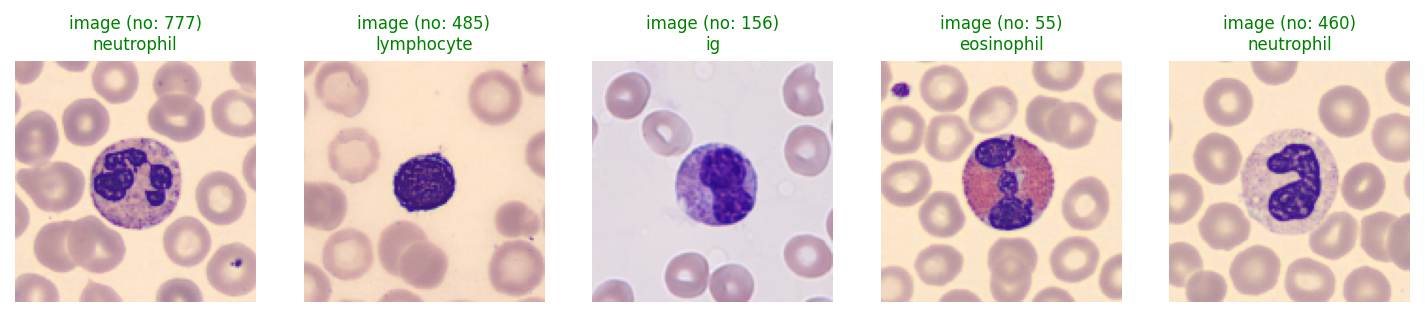

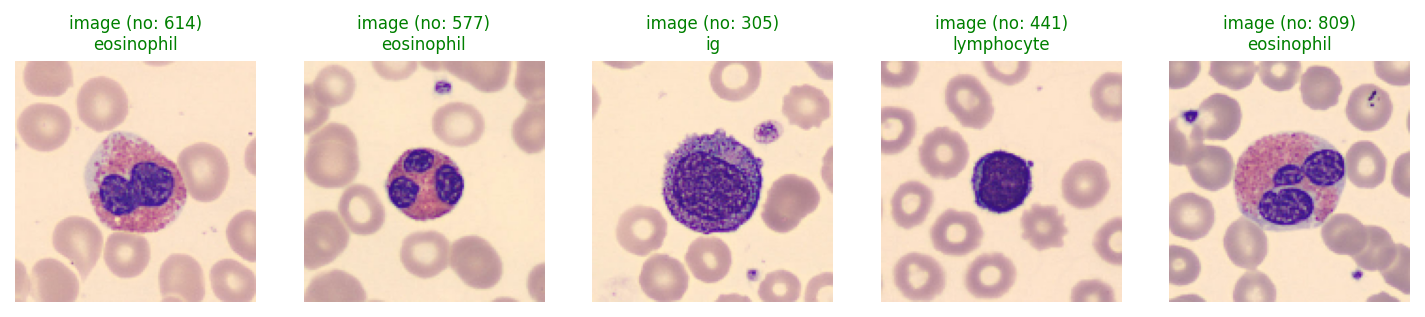

In [16]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 30)
random_test_sample_with_prediction(SEED = 40)
random_test_sample_with_prediction(SEED = 50)
random_test_sample_with_prediction(SEED = 60)